## Investigating historic horse-race data from './SFF_16_20.csv'

> This is race data from a 3rd party provider that provides courses length, weather conditions, trainers, weight, age, speed run in race, comments, results etc. Available for a small fee from the website:
[https://www.racingformbook.com/single-csv-racing-results/](https://www.racingformbook.com/single-csv-racing-results/)
>This notebook looks at the data, how it's presented and useful fields that might be of interest for cleaning/determining what features we can construct for pricing predictions. Typically we plot the .value_counts of the important columns in the data import to show a visual representation of what the breakdown of individual categories looks like.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper_functions import *

In [2]:
data = pd.read_csv('./SFF_16_20.csv')[['Id','Course','RaceDate','RaceTime','Race','Type','Class','Prize','Ran','Yards','Going','Seconds','FPos','TotalBtn','HorseName','Draw','Sp','Age','WeightLBS','Aid','Trainer','Jockey','Allow','OR']]
data.head()

C:\Program Files (x86)\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (22,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Id,Course,RaceDate,RaceTime,Race,Type,Class,Prize,Ran,Yards,...,HorseName,Draw,Sp,Age,WeightLBS,Aid,Trainer,Jockey,Allow,OR
0,42370101,Catterick,2016-01-01,12:30:00,Happy New Year Novices Hurdle,h,4.0,5198.0,12,4246,...,Lady Yeats,NaN,4.5,5,153,NaN,G M Moore,Joe Colliver,3,120.0
1,42370101,Catterick,2016-01-01,12:30:00,Happy New Year Novices Hurdle,h,4.0,5198.0,12,4246,...,Nam Hai,NaN,4.0,5,153,NaN,K C Bailey,Thomas Bellamy,3,NaN
2,42370101,Catterick,2016-01-01,12:30:00,Happy New Year Novices Hurdle,h,4.0,5198.0,12,4246,...,Fort Smith,NaN,1.1,7,149,t,Sam Thomas,Harrison Beswick,7,124.0
3,42370101,Catterick,2016-01-01,12:30:00,Happy New Year Novices Hurdle,h,4.0,5198.0,12,4246,...,Lough Salt,NaN,14.0,5,151,NaN,Mr M T Walford,Jamie Hamilton,5,NaN
4,42370101,Catterick,2016-01-01,12:30:00,Happy New Year Novices Hurdle,h,4.0,5198.0,12,4246,...,Cactus Valley,NaN,66.0,7,153,t,M W Easterby,Harry Bannister,3,NaN


## Going (Weather Condition)

In [3]:
grouped_df = data.groupby('Id').agg('first')
grouped_df['Going'] = grouped_df['Going'].apply(lambda x : remove_brackets(str(x)).strip())

Good                                                                15870
Standard                                                            11695
Soft                                                                 8871
Good to Firm                                                         8023
Good to Soft                                                         6596
Heavy                                                                4173
Standard / Slow                                                      2432
Yielding                                                             1414
Good to Yielding                                                     1017
Soft to Heavy                                                         928
Yielding to Soft                                                      650
Firm                                                                  387
Fast                                                                   51
Very Soft                             

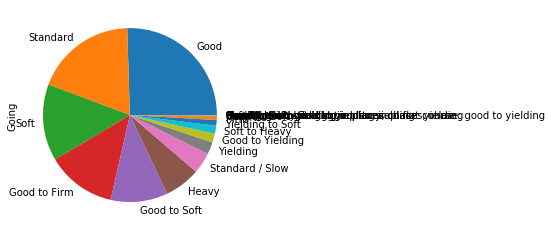

In [4]:
%matplotlib inline
grouped_df['Going'].value_counts(dropna=False).plot(kind='pie')
print(grouped_df['Going'].value_counts(dropna=False))

>We decide to cut the dataset to the 7 largest going categories to avoid overfitting and for conciceness. The top 7 account for 85%+ of the data

In [5]:
grouped_df = grouped_df[grouped_df['Going'].isin(grouped_df['Going'].value_counts()[:7].keys())]

### Country

In [6]:
grouped_df['Country'] = grouped_df['Course'].apply(lambda x: country_map(x))

GB     48303
IRE     8479
NI       495
FR       240
UAE       80
GER       18
QA        10
AUS        8
ITY        7
TUR        5
HK         4
SPA        3
SWE        2
CAN        2
SWI        1
BEL        1
NOR        1
KOR        1
Name: Country, dtype: int64


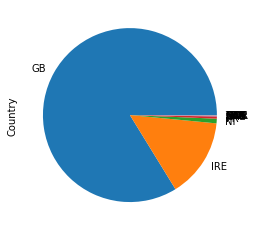

In [7]:
%matplotlib inline
grouped_df['Country'].value_counts(dropna=False).plot(kind='pie')
print(grouped_df['Country'].value_counts(dropna=False))

> Interesting there are no US courses here, given there are a lot of US races listed on Betfair regularly. Probably the data provider doesn't cover US races. This would be something to look at getting further down the line, but we should have sufficient data to develop models/ strategies with only GB and IRE races, which also have larger trading volumes in general. We decide to cut the frame to the 2 largest country categories GB and IRE which account for 95%+ of the dataset entries 

In [8]:
grouped_df = grouped_df[grouped_df['Country'].isin(['GB','IRE'])]

## Courses

Wolverhampton        2965
Lingfield            2770
Kempton              2685
Chelmsford City      2144
Newcastle            2114
                     ... 
Kilbeggan (IRE)       176
Bellewstown (IRE)     175
Sligo (IRE)           166
Bangor-On-Dee         160
Laytown (IRE)          24
Name: Course, Length: 85, dtype: int64


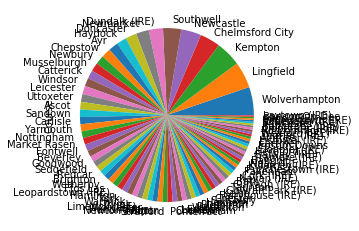

In [9]:
%matplotlib inline
grouped_df['Course'].value_counts(dropna=False).plot(kind='pie')
print(grouped_df['Course'].value_counts(dropna=False))

> We make no cuts on courses, all of them have numerous race datapoints

## Types

> In the appropriate documentation there are 3 race-types listed, b=flat, h=hurdle, c = chase

NaN    34816
h      12038
c       8079
b       1849
Name: Type, dtype: int64


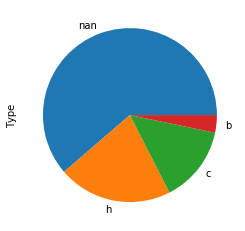

In [10]:
%matplotlib inline
grouped_df['Type'].value_counts(dropna=False).plot(kind='pie')
print(grouped_df['Type'].value_counts(dropna=False))

# Remove handicapping

> In horse racing, handicap races enable horses of varied ability to race competitively against each other via the allocation of weight. We want to remove these races as they do not give an unbiased estimate of a horse/racers intrinsic ability.

In [11]:
grouped_df=grouped_df[~grouped_df['Race'].str.contains("andicap")]

NaN    12527
h       5549
c       2182
b       1846
Name: Type, dtype: int64


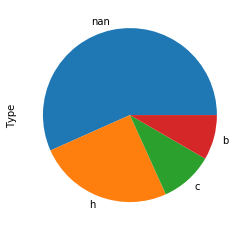

In [12]:
%matplotlib inline
grouped_df['Type'].value_counts(dropna=False).plot(kind='pie')
print(grouped_df['Type'].value_counts(dropna=False))

## Runners

> It's interesting to see how many races each horse typically runs before retiring:

In [13]:
data['Country'] = data['Course'].apply(lambda x: country_map(x))
data = data[data['Country'].isin(['GB','IRE'])]

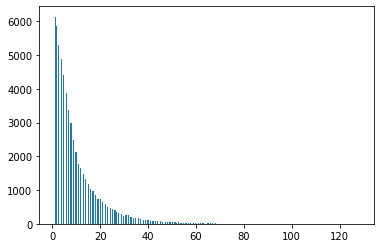

In [14]:
plt.hist(data['HorseName'].value_counts(dropna=False), bins='auto')
plt.show()